<a href="https://colab.research.google.com/github/asokraju/ml-grinding/blob/master/hands_on_ml/housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-On Machine Learning with Scikit-Learn & TensorFlow

Chapter 2

End-to-End Machine Learning Project


#imports

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pprint as pp

import os
import urllib
import tarfile
import urllib.request
from zipfile import ZipFile

import scipy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.externals import joblib

from pandas.plotting import scatter_matrix

np.random.seed(42)
random.seed(42)

#Data

##Downloading data

In [ ]:
def fetch_zip_data(source_url, local_path, file_name = 'original_file.zip'):
    """
    downloading the zip file from the 'sorce_url' to 'local_path'
    with file name as 'file_name'
    """
    if not os.path.isdir(local_path):
        os.makedirs(local_path)
    local_file = os.path.join(local_path, file_name)
    urllib.request.urlretrieve(download_url, local_file)

    #extracting the contents of the zip file
    with ZipFile(local_file, 'r') as zipObj:
        zipObj.printdir() 
        zipObj.extractall(local_path)
    
    #printing the file list
    files = os.listdir(local_path)
    print(files)

In [ ]:
download_url = 'http://lib.stat.cmu.edu/datasets/houses.zip'
local_path = './datasets/housing'
fetch_zip_data(source_url = download_url, local_path = local_path)
# git_url = "https://raw.githubusercontent.com/ageron/handson-ml/master/" + "datasets/housing" + "/housing.tgz"
# fetch_zip_data(source_url = git_url, local_path = local_path)
# df_original = pd.read_csv(local_path+"/cadata.txt")
# #making a deep copy, we work on the new deep copy
# df = df_original.copy(deep=True)

File Name                                             Modified             Size
cadata.txt                                     1999-11-05 03:05:10      4686855
['cadata.txt', 'original_file.zip']


In [ ]:
col_names = ['medianhousevalue','median_income','housingmedianage','total_rooms','total_bedrooms','population','households','latitude','longitude']

df_original = pd.read_csv(local_path+"/cadata.txt", names = col_names, skiprows=27, header=None, sep = '\s+')
#making a deep copy, we work on the new deep copy
df = df_original.copy(deep=True)

In [ ]:
df.head(5)

,medianhousevalue,median_income,housingmedianage,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   medianhousevalue  20640 non-null  float64
 1   median_income     20640 non-null  float64
 2   housingmedianage  20640 non-null  float64
 3   total_rooms       20640 non-null  float64
 4   total_bedrooms    20640 non-null  float64
 5   population        20640 non-null  float64
 6   households        20640 non-null  float64
 7   latitude          20640 non-null  float64
 8   longitude         20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
df.describe()

,medianhousevalue,median_income,housingmedianage,total_rooms,total_bedrooms,population,households,latitude,longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,206855.816909,3.870671,28.639486,2635.763081,537.898014,1425.476744,499.539680,35.631861,-119.569704
std,115395.615874,1.899822,12.585558,2181.615252,421.247906,1132.462122,382.329753,2.135952,2.003532
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000
25%,119600.000000,2.563400,18.000000,1447.750000,295.000000,787.000000,280.000000,33.930000,-121.800000
50%,179700.000000,3.534800,29.000000,2127.000000,435.000000,1166.000000,409.000000,34.260000,-118.490000
75%,264725.000000,4.743250,37.000000,3148.000000,647.000000,1725.000000,605.000000,37.710000,-118.010000
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000


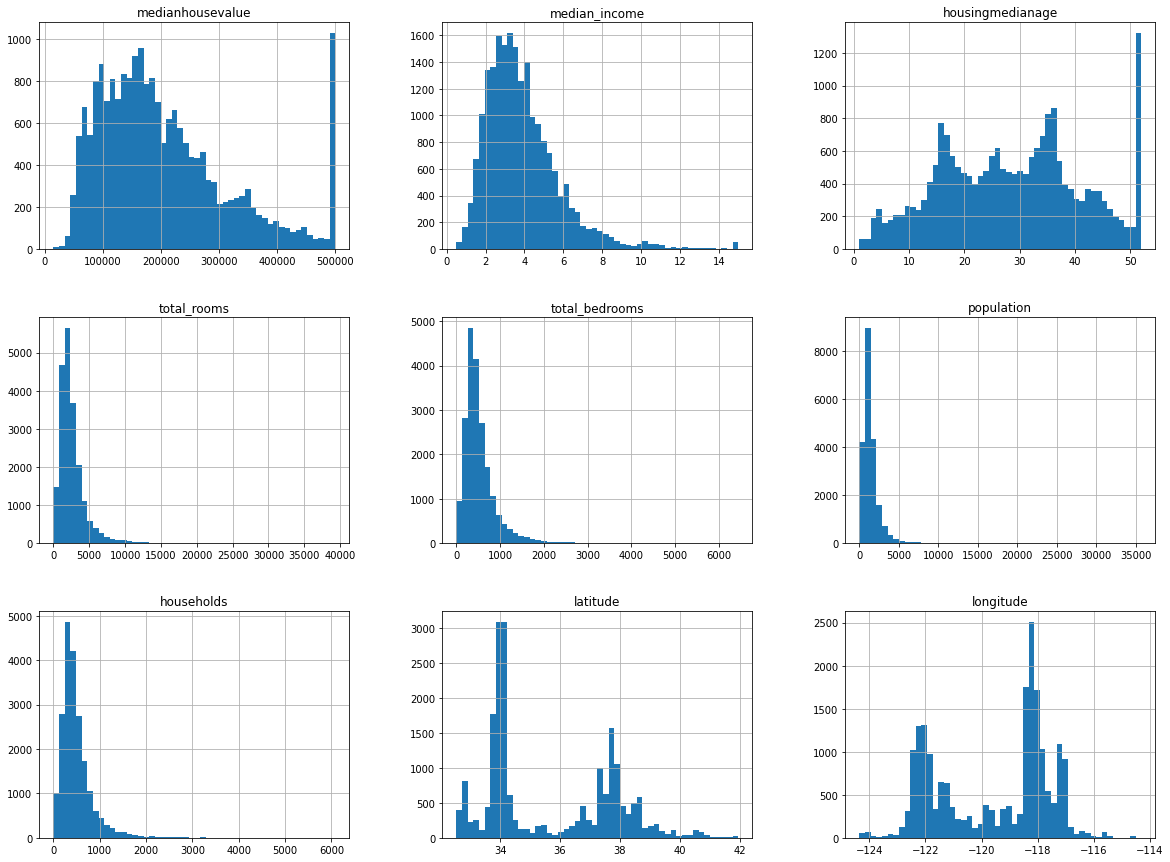

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

## Shufling the data

In [ ]:
def split_train_test(data, test_ratio = 0.2):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(df)
print("test : ",len(test_set),"\ntrain : ",len(train_set))

test :  4128 
train :  16512


In [ ]:
print(len(test_set), len(train_set))

4128 16512


In [ ]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state = 42)
print("test : ",len(test_set),"\ntrain : ",len(train_set))

test :  4128 
train :  16512


##Stratified shuffling

We will catogoize the income feature and use it for stratified shuffling

In [ ]:
df['income_cat'] = np.ceil(df['median_income'] / 1.5)
df['income_cat'].where(df['income_cat'] < 5, 5, inplace = True)
df['income_cat'] = df['income_cat'].astype('category')

#df['income_cat_1'] = df['median_income'].apply(lambda x: np.ceil(x/1.5) if np.ceil(x/1.5)<5 else 5)
#df.drop('income_cat_1', 1, inplace=True)
df.head()

,medianhousevalue,median_income,housingmedianage,total_rooms,total_bedrooms,population,households,latitude,longitude,income_cat
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23,5.0
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22,5.0
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24,5.0
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25,4.0
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25,3.0


In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]
print("test : ",len(strat_test_set),"\ntrain : ",len(strat_train_set))

test :  4128 
train :  16512


In [ ]:
strat_test_set.head()

,medianhousevalue,median_income,housingmedianage,total_rooms,total_bedrooms,population,households,latitude,longitude,income_cat
5241,500001.0,8.2816,29.0,6447.0,1012.0,2184.0,960.0,34.12,-118.39,5.0
10970,240300.0,4.6111,39.0,4159.0,655.0,1669.0,651.0,33.77,-117.86,4.0
20351,218200.0,3.0119,27.0,4357.0,926.0,2110.0,876.0,34.21,-119.05,3.0
6568,182100.0,4.1518,52.0,1786.0,306.0,1018.0,322.0,34.20,-118.15,3.0
13285,121300.0,4.0375,32.0,1775.0,314.0,1067.0,302.0,34.07,-117.68,3.0


In [ ]:
strat_train_set.head()

,medianhousevalue,median_income,housingmedianage,total_rooms,total_bedrooms,population,households,latitude,longitude,income_cat
17606,286600.0,2.7042,38.0,1568.0,351.0,710.0,339.0,37.29,-121.89,2.0
18632,340600.0,6.4214,14.0,679.0,108.0,306.0,113.0,37.05,-121.93,5.0
14650,196900.0,2.8621,31.0,1952.0,471.0,936.0,462.0,32.77,-117.20,2.0
3230,46300.0,1.8839,25.0,1847.0,371.0,1460.0,353.0,36.31,-119.61,2.0
3555,254500.0,3.0347,17.0,6592.0,1525.0,4459.0,1463.0,34.23,-118.59,3.0


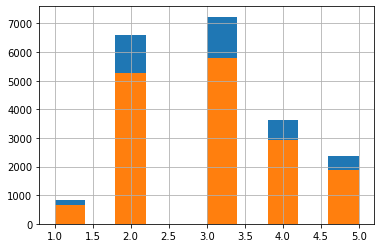

     train_set  test_set  complete_data  test/total
3.0       5789      1447           7236    0.199972
2.0       5265      1316           6581    0.199970
4.0       2911       728           3639    0.200055
5.0       1889       473           2362    0.200254
1.0        658       164            822    0.199513


In [ ]:
df['income_cat'].hist()
strat_train_set['income_cat'].hist()
plt.show()

temp = pd.DataFrame(strat_train_set['income_cat'].value_counts())
temp.columns = ['train_set']
temp['test_set'] = strat_test_set['income_cat'].value_counts()
temp['complete_data'] = df['income_cat'].value_counts()

temp['test/total'] = temp['test_set']/temp['complete_data']
print(temp)

In [ ]:
for set in (strat_test_set,strat_train_set):
    set.drop("income_cat", axis= 1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
for set in (strat_test_set,strat_train_set):
    print(set.head())

       medianhousevalue  median_income  ...  latitude  longitude
5241           500001.0         8.2816  ...     34.12    -118.39
10970          240300.0         4.6111  ...     33.77    -117.86
20351          218200.0         3.0119  ...     34.21    -119.05
6568           182100.0         4.1518  ...     34.20    -118.15
13285          121300.0         4.0375  ...     34.07    -117.68

[5 rows x 9 columns]
       medianhousevalue  median_income  ...  latitude  longitude
17606          286600.0         2.7042  ...     37.29    -121.89
18632          340600.0         6.4214  ...     37.05    -121.93
14650          196900.0         2.8621  ...     32.77    -117.20
3230            46300.0         1.8839  ...     36.31    -119.61
3555           254500.0         3.0347  ...     34.23    -118.59

[5 rows x 9 columns]


#Visualize the data

In [ ]:
train = strat_train_set.copy()

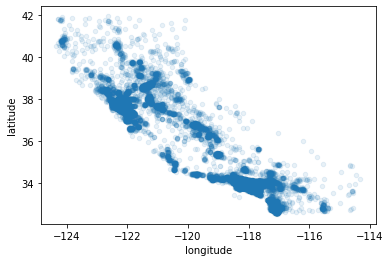

In [ ]:
train.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha=0.1)
plt.show()

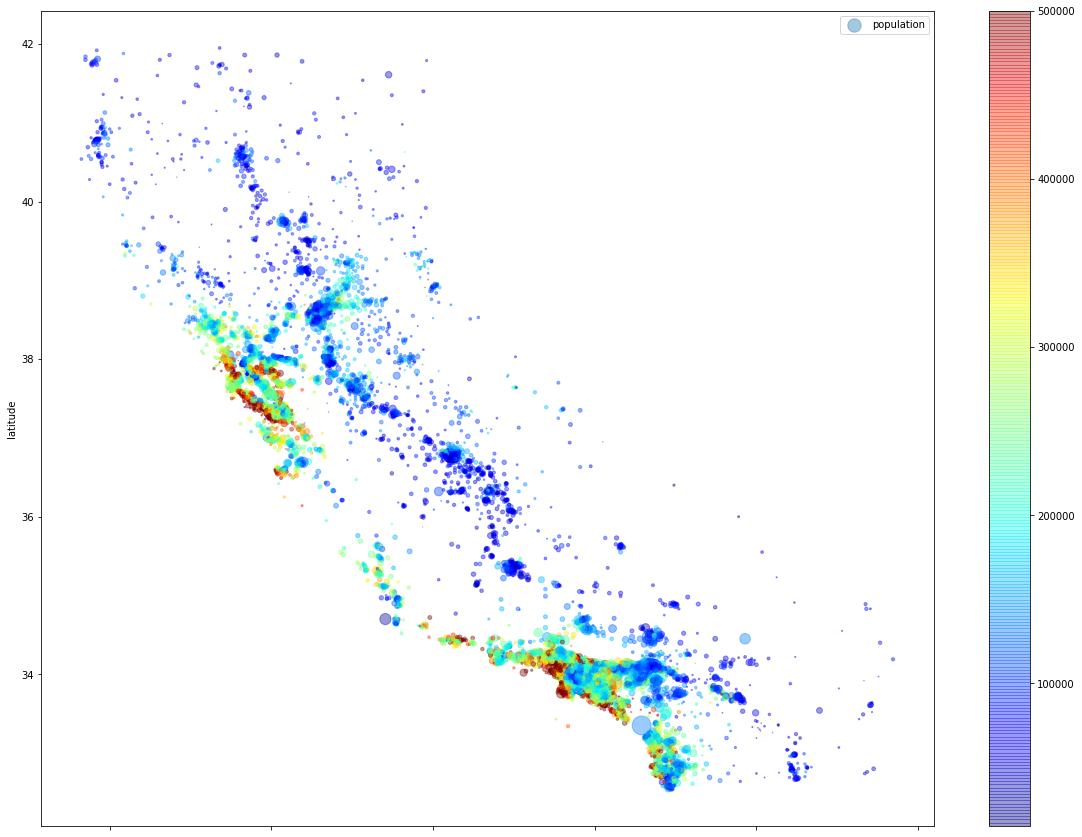

In [ ]:
train.plot(kind = 'scatter', x = 'longitude', 
           y = 'latitude', alpha=0.4,
           s = train['population']/100, label = "population",
           c = train['medianhousevalue'], cmap = plt.get_cmap("jet"), 
           colorbar = True, figsize = (20,15))
plt.legend()

## Scatter Matrix

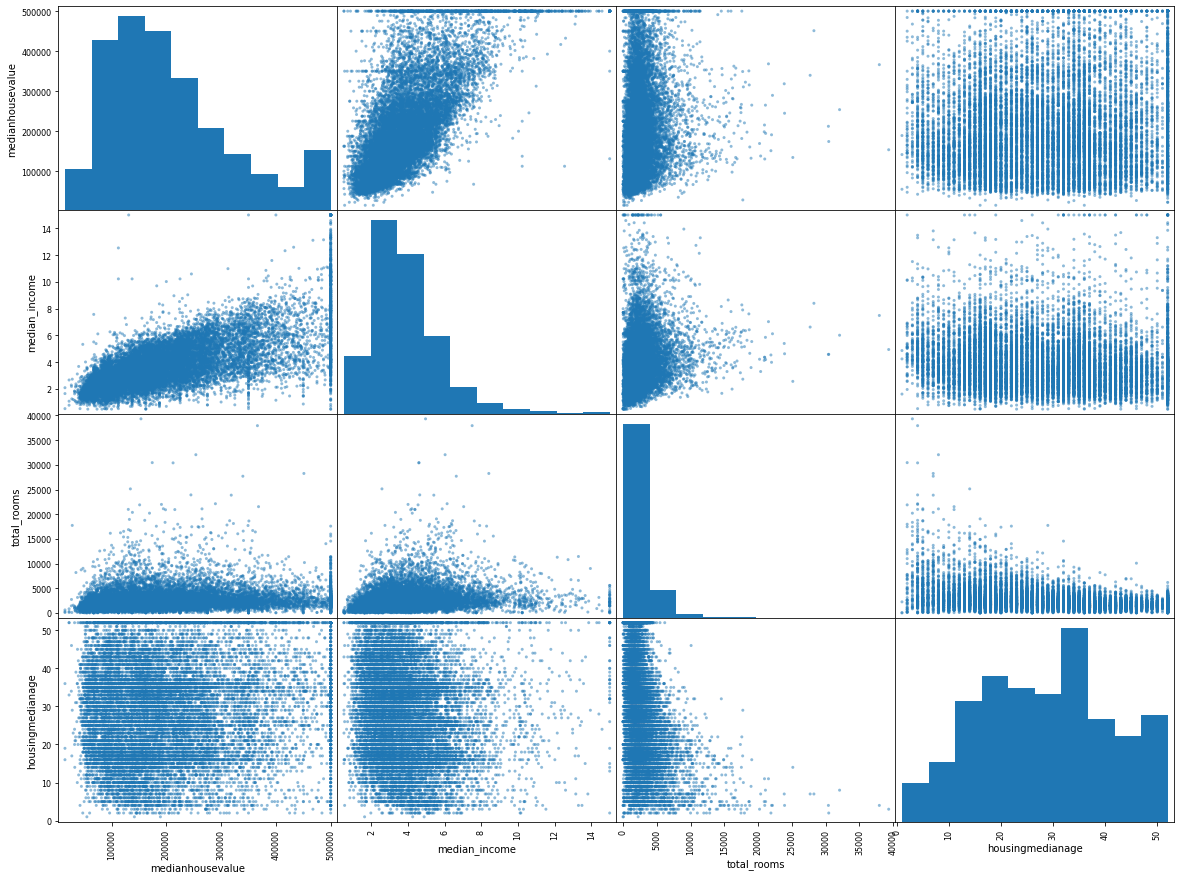

In [ ]:
#attributes = ['medianhousevalue','median_income','housingmedianage','total_rooms','total_bedrooms','population','households','latitude','longitude']
attributes = ['medianhousevalue', 'median_income', 'total_rooms', 'housingmedianage']
scatter_matrix(train[attributes], figsize=(20,15))
plt.show()

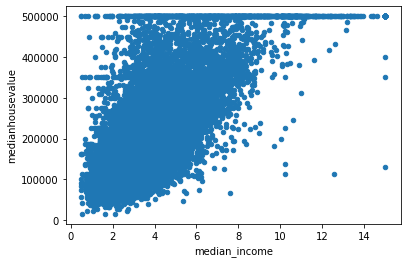

In [ ]:
train.plot(kind='scatter', x ='median_income', y = 'medianhousevalue')

# Adding new features

In [ ]:
#attributes = ['medianhousevalue','median_income','housingmedianage','total_rooms','total_bedrooms','population','households','latitude','longitude']
train['rooms_per_household'] = train['total_rooms']/train["households"]
train['bedrooms_per_room'] = train['total_bedrooms']/train['households']
train['population_per_household'] = train['population']/train['households']

In [ ]:
corr_matrix = train.corr()
corr_matrix['medianhousevalue'].sort_values(ascending=False)

medianhousevalue            1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housingmedianage            0.114110
households                  0.064506
total_bedrooms              0.048494
population_per_household   -0.021985
population                 -0.026920
bedrooms_per_room          -0.043289
longitude                  -0.047432
latitude                   -0.142724
Name: medianhousevalue, dtype: float64

#Data Cleaning

In [ ]:
train = strat_train_set.drop('medianhousevalue', axis = 1)
train_labels = strat_train_set['medianhousevalue'].copy()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   median_income     16512 non-null  float64
 1   housingmedianage  16512 non-null  float64
 2   total_rooms       16512 non-null  float64
 3   total_bedrooms    16512 non-null  float64
 4   population        16512 non-null  float64
 5   households        16512 non-null  float64
 6   latitude          16512 non-null  float64
 7   longitude         16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(train)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [ ]:
imputer.statistics_

array([   3.5409,   29.    , 2119.5   ,  433.    , 1164.    ,  408.    ,
         34.26  , -118.51  ])

In [ ]:
X =imputer.transform(train)
train_tr = pd.DataFrame(X, columns=train.columns)

## Classes


In [ ]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [ ]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
train_extra_attribs = attr_adder.transform(train.values)

## pipelines

In [ ]:
num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())
])
train_num_tr = num_pipeline.fit_transform(train)


In [ ]:
#I want to add an extra catogorival feature to the pipeline
train['income_cat'] = np.ceil(train['median_income'] / 1.5)
train['income_cat'].where(train['income_cat'] < 5, 5, inplace = True)
train['income_cat'] = train['income_cat'].astype('category')

# median_income_ix, rooms_ix, bedrooms_ix, population_ix, household_ix = 1, 3, 4, 5, 6
# class CombinedAttributesAdder_1(BaseEstimator, TransformerMixin):
#     def __init__(self, add_bedrooms_per_room = True, add_income_cat = True):
#         self.add_bedrooms_per_room = add_bedrooms_per_room
#         self.add_income_cat = True
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X, y=None):
#         rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
#         population_per_household = X[:, population_ix] / X[:, household_ix]
#         if self.add_bedrooms_per_room:
#             bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
#             if self.add_income_cat:
#                 temp = np.ceil(X[:, median_income_ix]/ 1.5)
#                 income_cat = np.array([np.ceil(i/1.5) if np.ceil(i/1.5)<5 else 5 for i in temp])
#                 return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room, income_cat]
#             else:
#                 return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
#         else:
#             if self.add_income_cat:
#                 temp = np.ceil(X[:, median_income_ix]/ 1.5)
#                 income_cat = np.array([np.ceil(i/1.5) if np.ceil(i/1.5)<5 else 5 for i in temp])
#                 return np.c_[X, rooms_per_household, population_per_household, income_cat]
#             else:
#                 return np.c_[X, rooms_per_household, population_per_household]

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_set):
        self.attributes_set = attributes_set
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attributes_set].values
# train_num = train.drop('income_cat', axis =1)
# num_attribs = list(train_num)
# cat_attribs = ['income_cat']
# dselect = DataFrameSelector(attributes_set = num_attribs)
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [ ]:
# train_num = train.drop('income_cat', axis =1)
# num_attribs = list(train_num)
# cat_attribs = ['income_cat']

# I have used set earlier, to clear the varible 
try:
    del set
except:
    pass
# attribs = list(train)
# num_attribs = list(train._get_numeric_data())
# cat_attribs = list(set(attribs)- set(num_attribs))
#train.select_dtypes(exclude=["number","bool_","object_"])

num_attribs = list(train.select_dtypes(include=["number"]))
cat_attribs = list(train.select_dtypes(include=["category"]))


num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_attribs)),
                         ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())
])
cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(cat_attribs)),
                        #  ('label_binarizer', MyLabelBinarizer())
                        ('one_hot_encoder', OneHotEncoder(sparse=False))
])

full_pipeline = FeatureUnion(transformer_list=[
                                               ('num_pipeline', num_pipeline),
                                               ('cat_pipeline', cat_pipeline)
])

train_prepared = full_pipeline.fit_transform(train)
train_prepared.shape

(16512, 20)

# Model Training

## Linear Regression

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(train_prepared, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
some_data = train.iloc[:5]
some_labels = train_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print(some_data_prepared[0])
#print(train_prepared[0])

print("Prediction:\t", lin_reg.predict(some_data_prepared))

[-0.61493744  0.74333089 -0.49323393 -0.44561824 -0.63621141 -0.42069842
  0.77194962 -1.15604281 -0.48081128 -0.45973783 -0.07161177  0.
  1.          0.          0.          0.        ]
Prediction:	 [199676.34534212 353861.25870847 198109.04030252  74925.4725904
 194918.98606179]


In [ ]:
housing_prediction=lin_reg.predict(train_prepared)
lin_mse = mean_squared_error(train_labels, housing_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68833.45576053654

##Decision Trees

In [ ]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_prepared, train_labels)
train_predictions = tree_reg.predict(train_prepared)
tree_mse = mean_squared_error(train_labels, train_predictions)
tree_mse

0.0

# CrossValidation

##Linear Regression

In [ ]:
scores_lr = cross_val_score(lin_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores_lr)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


In [ ]:
display_scores(rmse_scores)

Scores: [67363.64789174 67133.65516631 69150.19688386 73238.40755141
 67793.78395446 71336.46402264 65347.73075735 68346.40761574
 72752.20047011 68551.17083895]
Mean: 69101.3665152569
Standard deviation: 2429.1053521614385


##Decision Trees

In [ ]:
scores_tree = cross_val_score(tree_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores_tree)
display_scores(tree_rmse_scores)

Scores: [69205.49878018 68790.95161175 71840.86683066 73557.08040411
 70726.3027211  72941.99053329 70280.68318356 72176.29859264
 75400.56040453 72630.54003995]
Mean: 71755.0773101762
Standard deviation: 1934.3048977667331


## Random Forests

In [ ]:
forest_reg = RandomForestRegressor()
forest_reg.fit(train_prepared, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
scores_forest = cross_val_score(forest_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores_forest)
display_scores(forest_rmse_scores)

## SVR

In [ ]:
svr_reg = SVR(C=1.0, epsilon=0.2)
svr_reg.fit(train_prepared, train_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
svr_reg = SVR(C=1.0, epsilon=0.2)
scores_svr = cross_val_score(svr_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-scores_forest)
display_scores(svr_rmse_scores)

NameError: ignored

# Saving the model

In [ ]:
joblib.dump(forest_reg, "my_model.pkl")
forest_reg = joblib.load("my_model.pkl")

#Fine tuning the model using GridSearchCV

## RandomForests

In [ ]:
param_grid = [
              {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_prepared, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
grid_search.best_params_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
    print(np.sqrt(-mean_score), params)

70519.76430554544 {'max_features': 2, 'n_estimators': 3}
61100.88767688079 {'max_features': 2, 'n_estimators': 10}
58703.31391992099 {'max_features': 2, 'n_estimators': 30}
64389.86429518797 {'max_features': 4, 'n_estimators': 3}
57149.4313801618 {'max_features': 4, 'n_estimators': 10}
54581.272536296856 {'max_features': 4, 'n_estimators': 30}
62996.34910592558 {'max_features': 6, 'n_estimators': 3}
55480.0134075419 {'max_features': 6, 'n_estimators': 10}
53305.9887404834 {'max_features': 6, 'n_estimators': 30}
61431.99646638439 {'max_features': 8, 'n_estimators': 3}
54492.00973441633 {'max_features': 8, 'n_estimators': 10}
52717.9267396999 {'max_features': 8, 'n_estimators': 30}
68743.49643233314 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
59278.23924837492 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
64381.050994141384 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
57244.721503453504 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

##SVR

In [ ]:
param_grid = [{'kernel':['linear', 'rbf', 'sigmoid'],
               'C' : [1., 20., 0.1,  100],
               'gamma':['auto', 'scale', 10]
              },
              {'kernel':['poly'],
               'C' : [1., 20., 0.1, 0.01, 100],
               'degree':[3, 5, 8, 12]
              }] 
svr_reg = SVR()
grid_search = GridSearchCV(svr_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_prepared, train_labels)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
    print(np.sqrt(-mean_score), params)

#Fine tuning the model using RandomizedSearchCV

In [ ]:
forest_reg = RandomForestRegressor()

param_distributions = dict(n_estimators=scipy.stats.randint(10, 100),
                           max_features=scipy.stats.randint(1, 30),
                           bootstrap = [True, False])
rand_search = RandomizedSearchCV(forest_reg, 
                                param_distributions, 
                                n_iter=30, 
                                scoring='neg_mean_squared_error', 
                                n_jobs=None, 
                                cv=5)
rand_search.fit(train_prepared, train_labels)

In [ ]:
rand_search.best_params_

{'bootstrap': True, 'max_features': 15, 'n_estimators': 99}

In [ ]:
rand_cvres = rand_search.cv_results_
for mean_score, params in zip(rand_cvres["mean_test_score"], rand_cvres['params']):
    print(np.sqrt(-mean_score), params)

#Exercises

## Pipelines

In [ ]:
train['income_cat'] = np.ceil(train['median_income'] / 1.5)
train['income_cat'].where(train['income_cat'] < 5, 5, inplace = True)
train['income_cat'] = train['income_cat'].astype('category')

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False, kw_args={"add_bedrooms_per_room": True})



##pipeline -A

In [ ]:
num_attribs = list(train.select_dtypes(include=["number"]))
cat_attribs = list(train.select_dtypes(include=["category"]))

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                         ('attribs_adder', attr_adder),
                         ('std_scaler', StandardScaler())
])


full_pipeline = ColumnTransformer([
                                   ('num', num_pipeline, num_attribs),
                                   ('cat', OneHotEncoder(sparse=False), cat_attribs)
])

train_prepared = full_pipeline.fit_transform(train)
train_prepared.shape

(16512, 16)

## pipeline B

In [ ]:
num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                         ('attribs_adder', attr_adder),
                         ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
pipeline_preprop = ColumnTransformer([
                                   ('num_pipeline', num_pipeline, num_attribs),
                                   ('cat_pipeline', cat_pipeline, cat_attribs)
])

num_attribs = list(train.select_dtypes(include=["number", 'int64', 'float64']))
cat_attribs = list(train.select_dtypes(include=["category",'object']))
print('cat_attribs: ', cat_attribs)
print('num_attribs: ', num_attribs)

train_prepared = pipeline_preprop.fit_transform(train)
train_prepared.shape

cat_attribs:  ['income_cat']
num_attribs:  ['median_income', 'housingmedianage', 'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude', 'longitude']


(16512, 16)

In [ ]:
rf = Pipeline([
               ('preprocess', pipeline_preprop),
               ('regressor', RandomForestRegressor())
])

In [ ]:
rf.fit(train, train_labels)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                      

In [ ]:
test = strat_test_set.drop('medianhousevalue', axis = 1)
test_labels = strat_test_set['medianhousevalue'].copy()
test['income_cat'] = np.ceil(test['median_income'] / 1.5)
test['income_cat'].where(test['income_cat'] < 5, 5, inplace = True)
test['income_cat'] = test['income_cat'].astype('category')
y_pred = rf.predict(test)

Pipeline C

In [ ]:
param_grid = [
              {'regressor__n_estimators': [3, 10, 30], 
               'regressor__max_features': [2, 4, 6, 8]},
              {'regressor__bootstrap': [False], 
               'regressor__n_estimators': [3, 10], 
               'regressor__max_features': [2, 3, 4]}
]
rf = Pipeline([
               ('preprocess', pipeline_preprop),
               ('regressor', RandomForestRegressor())
])

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                             

In [ ]:

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
    print(np.sqrt(-mean_score), params)
grid_search.best_params_


70410.54996864594 {'regressor__max_features': 2, 'regressor__n_estimators': 3}
60835.19000141955 {'regressor__max_features': 2, 'regressor__n_estimators': 10}
57840.98242152835 {'regressor__max_features': 2, 'regressor__n_estimators': 30}
65006.70694449081 {'regressor__max_features': 4, 'regressor__n_estimators': 3}
57031.75937256397 {'regressor__max_features': 4, 'regressor__n_estimators': 10}
54752.4411914197 {'regressor__max_features': 4, 'regressor__n_estimators': 30}
63684.87878615331 {'regressor__max_features': 6, 'regressor__n_estimators': 3}
55833.53413167558 {'regressor__max_features': 6, 'regressor__n_estimators': 10}
52983.21883018996 {'regressor__max_features': 6, 'regressor__n_estimators': 30}
60854.24141205762 {'regressor__max_features': 8, 'regressor__n_estimators': 3}
55049.4445052601 {'regressor__max_features': 8, 'regressor__n_estimators': 10}
52584.060297502554 {'regressor__max_features': 8, 'regressor__n_estimators': 30}
67484.36999137086 {'regressor__bootstrap': Fa

{'regressor__max_features': 8, 'regressor__n_estimators': 30}

## Pipeline D

In [ ]:
import pprint as pp

param_grid = [
              {'regressor__n_estimators': [3, 10, 30], 
               'regressor__max_features': [2, 4, 6, 8],
               'preprocess__num_pipeline__imputer__strategy': ['mean', 'median'],
               'preprocess__num_pipeline__attribs_adder__kw_args' : [{"add_bedrooms_per_room": True}, {"add_bedrooms_per_room": False}]},
              {'regressor__bootstrap': [False], 
               'regressor__n_estimators': [3, 10], 
               'regressor__max_features': [2, 3, 4],
               'preprocess__num_pipeline__imputer__strategy': ['mean', 'median'],
               'preprocess__num_pipeline__attribs_adder__kw_args' : [{"add_bedrooms_per_room": True}, {"add_bedrooms_per_room": False}]}
]
rf = Pipeline([
               ('preprocess', pipeline_preprop),
               ('regressor', RandomForestRegressor())
])
pp.pprint(sorted(rf.get_params().keys()))


In [ ]:
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                             

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
    print(np.sqrt(-mean_score), params)
grid_search.best_params_

70674.67235770765 {'preprocess__num_pipeline__attribs_adder__kw_args': {'add_bedrooms_per_room': True}, 'preprocess__num_pipeline__imputer__strategy': 'mean', 'regressor__max_features': 2, 'regressor__n_estimators': 3}
60915.71329874833 {'preprocess__num_pipeline__attribs_adder__kw_args': {'add_bedrooms_per_room': True}, 'preprocess__num_pipeline__imputer__strategy': 'mean', 'regressor__max_features': 2, 'regressor__n_estimators': 10}
58194.256692322 {'preprocess__num_pipeline__attribs_adder__kw_args': {'add_bedrooms_per_room': True}, 'preprocess__num_pipeline__imputer__strategy': 'mean', 'regressor__max_features': 2, 'regressor__n_estimators': 30}
64863.531537211165 {'preprocess__num_pipeline__attribs_adder__kw_args': {'add_bedrooms_per_room': True}, 'preprocess__num_pipeline__imputer__strategy': 'mean', 'regressor__max_features': 4, 'regressor__n_estimators': 3}
57291.59263315678 {'preprocess__num_pipeline__attribs_adder__kw_args': {'add_bedrooms_per_room': True}, 'preprocess__num_pi

{'preprocess__num_pipeline__attribs_adder__kw_args': {'add_bedrooms_per_room': True},
 'preprocess__num_pipeline__imputer__strategy': 'mean',
 'regressor__max_features': 8,
 'regressor__n_estimators': 30}

# Final setup